# Multi-armed bandit

In the [multi-armed bandit](https://en.wikipedia.org/wiki/Multi-armed_bandit) problem we try to maximise our gain over time by "gambling on slot-machines" that have different (but unknown) expected outcomes.

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from IPython.core.pylabtools import figsize
sns.set_style('darkgrid')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
# Define the multi-armed bandits
nb_bandits = 3  # Number of bandits
p_bandits = [0.45, 0.55, 0.60]  # True probability of winning for each bandit

def pull(i):
    """Pull arm of bandit with index `i` and return 1 if win, else return 0."""
    if np.random.rand() < p_bandits[i]:
        return 1
    else:
        return 0


Each pull of a specifc bandit will give a win with a certain probability. The higher this probability the more likely pulling the arm of the bandit is going to result in a win. However we don't know what this probability is so we will have to model it based on our observations of a certain bandit resulting in a win or not. We are going to model the unkown probability with a parameter $\theta$. Based on oberving a single outcome $x$ we can model this as the distribution $P(\theta \mid x)$. Using [Bayes rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) we can write this as:

$$
P(\theta \mid x) = \frac{P(x \mid \theta)P(\theta)}{P(x)}
$$

$P(\theta \mid x)$ is called the posterior distribution of $\theta$ after observing $x$. We will be able to compute this via the conditional distribution $P(x \mid \theta)$ and prior $P(\theta)$. The conditional distribution $P(x \mid \theta)$ in this case follows the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution). A good choice for the prior $P(\theta)$ would be the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) since it is a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior#Discrete_distributions) to the Bernoulli distribution. This means that if we choose the Beta distribution as a prior that the posterior will also be a Beta distribution. More specifically if the prior is $Beta(\alpha, \beta)$ then after observing a win $x=1$ the posterior would become $Beta(\alpha+1, \beta)$ or after observing a loss $x=0$ the posterior would become $Beta(\alpha, \beta+1)$.

This means that after every observation we can use the posterior as the prior for the next time we pull the bandit's arm.

The goal of the muli-armed bandit problem is to maximise reward (minimise regret). There is an exploitation-exploration tradeoff we have to make here. The more we pull the arm of our percieved best bandit the more certain we become of the probability of that bandit. But other bandits that we haven't pulled that often might have a lower mean probability, but more uncertainty of that probability so there is a change that they are actually better than our percieved best bandit.

We will use [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling) to overcome this problem. In Thompson sampling we will for each bandit sample the probability $\theta$ from the prior and pull the bandit with the highest sampled probability. And repeat this step until finished.

We will start with the prior $Beta(\alpha=1, \beta=1)$, which corresponds to a uniform prior between 0 and 1.

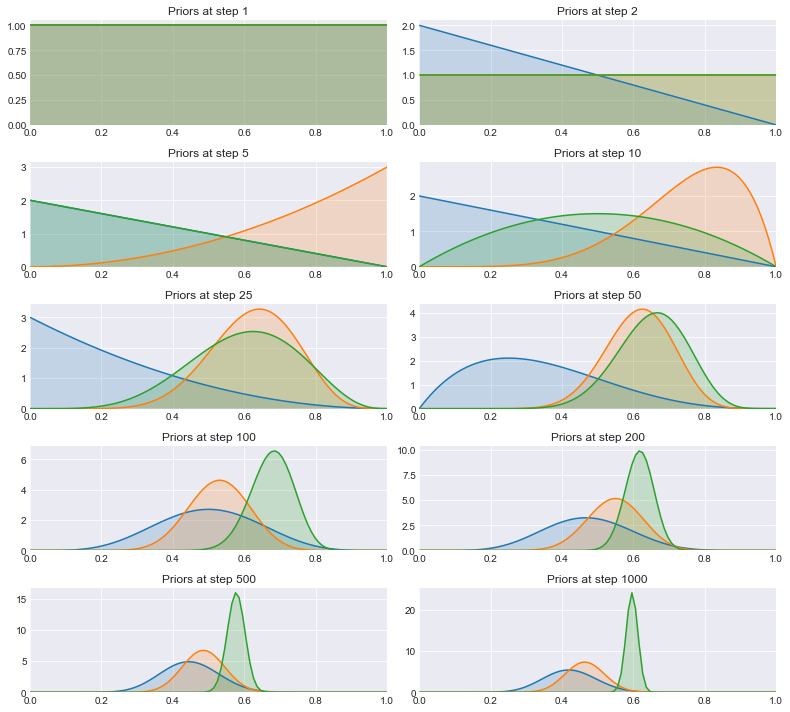

In [3]:
# Run algorithim and plot priors from time to time
# Define plotting functions
plots = [1, 2, 5, 10, 25, 50, 100, 200, 500, 1000] # Plot at this iteration

plot_idx = 1
figsize(11.0, 10)
def plot(priors, step):
    global plot_idx
    plt.subplot(5, 2, plot_idx) 
    plot_x = np.linspace(0.001, .999, 100)
    for prior in priors:
        y = prior.pdf(plot_x)
        p = plt.plot(plot_x, y)
        plt.fill_between(plot_x, y, 0, alpha=0.2)
    plt.xlim([0,1])
    plt.ylim(ymin=0)
    plt.title('Priors at step {}'.format(step))
    plot_idx += 1

# Simulate multi-armed bandit process and update posterior
# The number of trials and wins will represent the prior for each
#  bandit with the help of the Beta distribution.
trials = [0, 0, 0]  # Number of times we tried each bandit
wins = [0, 0, 0]  # Number of wins for each bandit

n = 1000
# Run the trail for `n` steps
for step in range(1, n+1):
    # Define the prior based on current observations
    bandit_priors = [
        stats.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    # plot prior 
    if step in plots:
        plot(bandit_priors, step)
    # Sample a probability theta for each bandit
    theta_samples = [
        d.rvs(1) for d in bandit_priors
    ]
    # choose a bandit
    chosen_bandit = np.argmax(theta_samples)
    # Pull the bandit
    x = pull(chosen_bandit)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x

plt.tight_layout()
plt.show()